## Initial exploratory analysis and generation of a baseline model

### 1) Data cleaning and pre-processing

In [1]:
# import packages
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
import gc
# Set figure stile and size for entire notebook
sns.set_style("ticks")
plt.rcParams["figure.figsize"] = (7,6)

In [2]:
# load data (train.csv will be the complete dataset for predictive modeling, ignore Test.csv for now)
data=pd.read_csv("./data/Train.csv")

A quick examination shows that the dataset contains an ID column, a location column indicating the sensor location, 6 feature variables containing sensor data to be used for target prediction, as well as the target itself.

The 6 feature variables are: temperature, precipitation, relative humidity, wind direction, wind speed, atmospheric pressure

For each observation, the data for the feature variables reflects the raw sensor measurements collected hourly over a 5-day period. These measurement periods are stored as a string per observation / feature. They thus need to be unpacked into list. As can be seen from the data table, each observation period contains varying degrees of missings (NaN), which need to be managed in a proper way. These missings occur either in the form of 'nan' or spaces in the string.
Also, it would be good to extract summary statistics from the different features for each recording period (e.g. mean, standard deviation, minimum, maximum) in order to engineer new features for the prediction.

The target represents the amount of PM2.5 particles in ug/m^3 measured exactly 24h after the end of the recording period for the feature measurements.

#### Convert the sensor data for each feature from string type into a list of values

In [3]:
# define a function to replace spaces in the string (i.e. missings) with NaN
def replace_nan(x):
    if x==" ":
        return np.nan
    else :
        return float(x)

# define list of feature names
features=["temp","precip","rel_humidity","wind_dir","wind_spd","atmos_press"]


for feature in features : 
    # first replace every 'nan' in a cell with an empty space, split using comma, and then apply replace_nan function on every item
    data[feature]=data[feature].apply(lambda x: [ replace_nan(X) for X in x.replace("nan"," ").split(",")])    

Thus, for every observation, each feature value is represented as a list of raw values over an hourly 5-day recording period

### Features engineering part

#### Extract summary statistics per observation period for every feature

In [4]:
data.columns.tolist()
 #aggregation function extracting summary statistics from every recording period and appending it as a new column to a dataframe
def aggregate_features(x,col_name):
    x["max_"+col_name]=x[col_name].apply(np.max)
    x["min_"+col_name]=x[col_name].apply(np.min)
    x["mean_"+col_name]=x[col_name].apply(np.mean)
    x["std_"+col_name]=x[col_name].apply(np.std)
    x["var_"+col_name]=x[col_name].apply(np.var)
    x["median_"+col_name]=x[col_name].apply(np.median)
    x["ptp_"+col_name]=x[col_name].apply(np.ptp)
    return x  

In [5]:
# I want to calculate the temperature per location only for now, just to see how the data behave in general

df_temp = data[['location', 'temp']]
# extract all single raw values from each column and append them as new columns to the dataframe

In [6]:
#here we define the empty data for temperature in the range without the index but with the name of the columns from 1-121
df_temp_121 = pd.DataFrame(columns=np.arange(121))
#taking the values of temperature from df_tem, from all the rows and the column temp
df_v=df_temp.iloc[0:,1]
# for loop for i (is a list) in df_v take each value from df_v and add to the empty dataframe --> dff_tmp
for i in df_v:
    df_temp_121.loc[len(df_temp_121)]=i

#after this loop, there should be a df with single colums each belogning to 15539 temperature measurements on the 121 hours

In [7]:
df_temp_121.shape

(15539, 121)

In [8]:
# concatenating all df of interest to make a df with my data of interest
tar=data['target']
df_121_tar= pd.concat([df_temp,df_temp_121,tar],axis=1)
df_121_tar.drop('temp',axis=1,inplace=True)

In [9]:
df_121_tar.head()

,location,0,1,2,3,4,5,6,7,8,...,112,113,114,115,116,117,118,119,120,target
0,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.550000,21.166667,21.000000,20.925000,20.358333,19.841667,19.275000,19.533333,19.583333,45.126304
1,D,22.533333,21.716667,20.833333,20.983333,20.875000,20.141667,19.375000,18.791667,18.775000,...,26.791667,27.833333,29.600000,30.233333,30.583333,28.466667,26.991667,26.025000,21.450000,79.131702
2,A,28.975000,27.950000,29.600000,26.425000,22.091667,21.775000,22.333333,21.950000,20.441667,...,20.733333,20.508333,20.441667,20.991667,23.541667,26.408333,28.075000,29.241667,30.091667,32.661304
3,A,22.966667,24.266667,25.275000,25.625000,25.866667,25.091667,24.025000,22.425000,20.233333,...,18.291667,18.075000,17.741667,17.625000,18.308333,20.325000,21.900000,23.533333,24.641667,53.850238
4,A,21.875000,21.575000,21.525000,21.433333,20.508333,19.916667,18.991667,18.591667,18.050000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,177.418750


In [10]:
#sorting the values for location
sorted_data=df_121_tar.sort_values('location')

In [11]:
sorted_data.head()

,location,0,1,2,3,4,5,6,7,8,...,112,113,114,115,116,117,118,119,120,target
12201,A,26.658333,27.700000,28.108333,27.566667,27.150000,23.458333,22.433333,20.958333,20.883333,...,17.933333,18.000000,17.925000,18.191667,18.866667,20.058333,21.983333,23.258333,24.641667,68.261905
3466,A,27.025000,NaN,28.658333,29.133333,29.483333,NaN,19.408333,NaN,21.325000,...,18.566667,18.127273,18.000000,NaN,19.066667,20.563636,22.600000,24.636364,25.641667,42.076977
6393,A,19.883333,19.983333,19.575000,19.491667,20.266667,19.866667,20.016667,19.983333,21.450000,...,30.618182,24.000000,24.258333,23.391667,23.858333,24.625000,24.416667,23.466667,23.041667,26.122500
3464,A,21.650000,21.425000,20.658333,21.441667,21.708333,21.166667,24.391667,28.966667,30.950000,...,24.433333,24.141667,24.058333,23.883333,20.800000,19.108333,18.883333,18.966667,19.175000,22.298864
3463,A,19.800000,19.408333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.654286


In [12]:
#Putting the names to the 121 hours, loc, temp and target
sorted_data.columns= ["location", "t1","t2", "t3","t4", "t5", "t6", "t7", "t8", "t9", "t10", "t11", "t12", "t13","t14","t15", 	"t16", 	"t17", 	"t18", 	"t19",	"t20", 	"t21", 	"t22", 	"t23", 	"t24",	"t25", 	"t26", 	"t27", 	"t28", 	"t29",	"t30", 	"t31", 	"t32", 	"t33", 	"t34",	"t35", 	"t36", 	"t37", 	"t38", 	"t39",	"t40", 	"t41", 	"t42", 	"t43", 	"t44",	"t45", 	"t46", 	"t47", 	"t48", 	"49",	"t50", 	"t51", 	"t52", 	"t53", 	"t54",	"t55", 	"t56", 	"t57", 	"t58", 	"t59",	"t60", 	"t61", 	"t62", 	"t63", 	"t64",	"t65", 	"t66", 	"t67", 	"t68", 	"t69",	"t70", 	"t71", 	"t72", 	"t73", 	"t74",	"t75", 	"t76", 	"t77", 	"t78", 	"t79",	"t80", 	"t81", 	"t82", 	"t83", 	"t84",	"t85", 	"t86", 	"t87", 	"t88", 	"t89",	"t90", 	"t91", 	"t92", 	"t93", 	"t94",	"t95", 	"t96", 	"t97", 	"t98", 	"t99",	"t100",	"t101", "t102", "t103", "t104",	"t105", "t106", "t107", "t108", "t109",	"t110", "t111", "t112", "t113", "t114",	"t115", "t116", "t117", "t118", "t119",	"t120", "tFinal", "target"]	

In [13]:
sorted_data.shape

(15539, 123)

In [14]:
#I wanted to work this data in excel, but the file convert into strange format, there is not possible to work there.
sorted_data.to_csv(r'data/ds-temp_sorted.csv')
#we have the data temperature in columns and location and the index and everything is sorted, i woould get rid of most samples only left 50 as a sample, first drop location for ploting
sorted_data.drop('location',axis=1,inplace=True)

In [15]:
#transposing the data to columns of Temperature because i dont know how to make otherwise plots :(
df_trans_Ttar= sorted_data.T

In [16]:
df_trans_Ttar.tail(2)

,12201,3466,6393,3464,3463,11130,8653,6394,3467,11133,...,8896,2252,2251,2248,5286,2244,12690,8890,8883,11209
tFinal,24.641667,25.641667,23.041667,19.175000,NaN,18.741667,27.133333,24.341667,20.216667,18.366667,...,21.316667,23.783333,18.983333,20.408333,21.366667,22.566667,28.466667,22.45,18.233333,23.033333
target,68.261905,42.076977,26.122500,22.298864,29.654286,33.647674,30.872500,46.779250,38.444186,62.102558,...,11.443333,42.460541,52.743750,12.212000,38.365476,30.410952,23.940000,39.76,71.721111,45.851628


In [17]:
#get the target, last column, out for now
df_trans_T=df_trans_Ttar.iloc[:121] 

In [18]:
df_trans_T.shape

(121, 15539)

In [19]:
#adding a column named temperature
df_trans_T["hour_t"]=["t1","t2", "t3","t4", "t5", "t6", "t7", "t8", "t9", "t10", "t11", "t12", "t13","t14","t15", 	"t16", 	"t17", 	"t18", 	"t19",	"t20", 	"t21", 	"t22", 	"t23", 	"t24",	"t25", 	"t26", 	"t27", 	"t28", 	"t29",	"t30", 	"t31", 	"t32", 	"t33", 	"t34",	"t35", 	"t36", 	"t37", 	"t38", 	"t39",	"t40", 	"t41", 	"t42", 	"t43", 	"t44",	"t45", 	"t46", 	"t47", 	"t48", 	"49",	"t50", 	"t51", 	"t52", 	"t53", 	"t54",	"t55", 	"t56", 	"t57", 	"t58", 	"t59",	"t60", 	"t61", 	"t62", 	"t63", 	"t64",	"t65", 	"t66", 	"t67", 	"t68", 	"t69",	"t70", 	"t71", 	"t72", 	"t73", 	"t74",	"t75", 	"t76", 	"t77", 	"t78", 	"t79",	"t80", 	"t81", 	"t82", 	"t83", 	"t84",	"t85", 	"t86", 	"t87", 	"t88", 	"t89",	"t90", 	"t91", 	"t92", 	"t93", 	"t94",	"t95", 	"t96", 	"t97", 	"t98", 	"t99",	"t100",	"t101", "t102", "t103", "t104",	"t105", "t106", "t107", "t108", "t109",	"t110", "t111", "t112", "t113", "t114",	"t115", "t116", "t117", "t118", "t119",	"t120", "tFinal"]

/var/folders/3f/b_krqwq149sd6c_2sg6s0r580000gn/T/ipykernel_53794/1421918131.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trans_T["hour_t"]=["t1","t2", "t3","t4", "t5", "t6", "t7", "t8", "t9", "t10", "t11", "t12", "t13","t14","t15", 	"t16", 	"t17", 	"t18", 	"t19",	"t20", 	"t21", 	"t22", 	"t23", 	"t24",	"t25", 	"t26", 	"t27", 	"t28", 	"t29",	"t30", 	"t31", 	"t32", 	"t33", 	"t34",	"t35", 	"t36", 	"t37", 	"t38", 	"t39",	"t40", 	"t41", 	"t42", 	"t43", 	"t44",	"t45", 	"t46", 	"t47", 	"t48", 	"49",	"t50", 	"t51", 	"t52", 	"t53", 	"t54",	"t55", 	"t56", 	"t57", 	"t58", 	"t59",	"t60", 	"t61", 	"t62", 	"t63", 	"t64",	"t65", 	"t66", 	"t67", 	"t68", 	"t69",	"t70", 	"t71", 	"t72", 	"t73", 	"t74",	"t75", 	"t76", 	"t77", 	"t78", 	"t79",	"t80", 	"t81", 

In [20]:
df_trans_T.head()

,12201,3466,6393,3464,3463,11130,8653,6394,3467,11133,...,2252,2251,2248,5286,2244,12690,8890,8883,11209,hour_t
t1,26.658333,27.025000,19.883333,21.650000,19.800000,19.166667,26.875000,24.425000,22.741667,18.816667,...,21.558333,20.641667,22.308333,NaN,25.558333,27.058333,18.008333,19.733333,20.891667,t1
t2,27.700000,NaN,19.983333,21.425000,19.408333,19.233333,25.425000,23.591667,21.908333,18.575000,...,21.050000,21.066667,21.908333,NaN,27.808333,25.166667,18.550000,19.991667,20.216667,t2
t3,28.108333,28.658333,19.575000,20.658333,NaN,19.733333,21.408333,22.491667,21.550000,18.291667,...,20.483333,21.733333,21.225000,NaN,29.241667,22.925000,19.275000,19.441667,19.441667,t3
t4,27.566667,29.133333,19.491667,21.441667,NaN,19.816667,23.225000,21.608333,21.758333,18.600000,...,20.558333,24.041667,21.300000,NaN,30.375000,22.316667,19.616667,20.291667,19.316667,t4
t5,27.150000,29.483333,20.266667,21.708333,NaN,19.941667,24.350000,21.066667,20.316667,19.325000,...,19.975000,25.808333,20.708333,NaN,29.550000,22.100000,19.641667,22.816667,19.308333,t5


In [21]:
#taken a slice of the df corresponding to the las 24 rows less target
df_trans_T24=df_trans_T.iloc[96:121] 

In [22]:
# list dataframe columns for temperature on last 24 hours and tendencies
df_trans_T24= df_trans_T24.iloc[: , :51]


In [23]:
#Putting the name of the location A column chosen
df_trans_T24.columns =["A1", "A2" , "A3","A4",  "A5",  "A6",  "A7",  "A8" , "A9" , "A10" , "A11" , "A12",  "A13" , "A14", "A15 ", "A16" , "A17"  ,"A18" , "A19" , "A20"  ,"A21"  ,"A22",  "A23" , "A24"  ,"A25",  "A26"  ,"A27" , "A28"  ,"A29" , "A30",  "A31",  "A32",  "A33" , "A34" , "A35" , "A36",  "A37" , "A38", "A39","A40" , "A41" , "A42",  "A43"  ,"A44" , "A45" , "A46"  ,"A47"  ,"A48" , "49" , "A50", "hour_t"]

In [24]:
df_trans_T24.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A42,A43,A44,A45,A46,A47,A48,49,A50,hour_t
t97,27.033333,26.716667,21.783333,20.133333,21.566667,21.175000,26.366667,22.033333,21.000000,20.300000,...,25.491667,23.666667,19.866667,21.625000,18.250000,20.033333,18.066667,23.600000,23.841667,24.858333
t98,28.033333,27.127273,20.700000,19.675000,20.775000,20.616667,26.516667,21.525000,20.075000,19.991667,...,26.358333,23.175000,19.981818,22.900000,18.208333,NaN,18.733333,25.208333,26.241667,24.000000
t99,28.175000,27.858333,20.750000,19.133333,NaN,20.450000,25.491667,21.100000,20.283333,19.933333,...,27.141667,22.741667,18.591667,24.583333,18.433333,NaN,19.725000,26.433333,27.500000,23.683333
t100,28.841667,NaN,21.150000,18.891667,NaN,20.408333,26.383333,20.500000,19.541667,19.641667,...,27.358333,22.141667,18.709091,25.666667,18.666667,NaN,22.683333,27.450000,28.725000,23.150000
t101,28.300000,27.716667,20.891667,18.616667,NaN,21.316667,25.691667,20.391667,19.533333,19.875000,...,27.783333,22.058333,19.358333,26.175000,19.025000,NaN,23.941667,27.800000,29.775000,22.516667


[Text(0.5, 1.0, 'Temperature last 24 hours')]

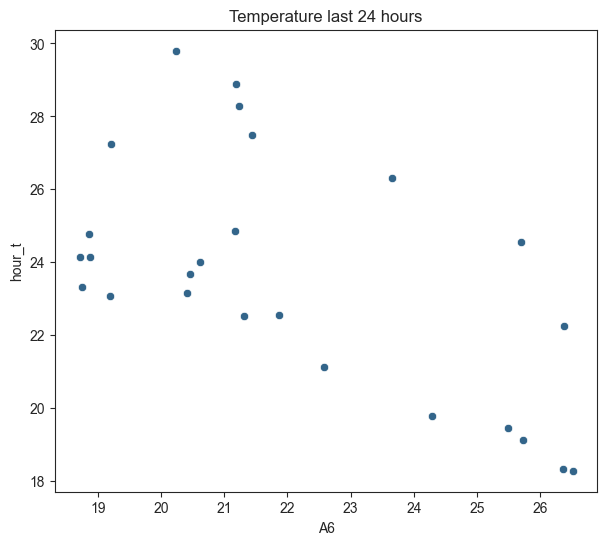

In [25]:
# Scattplot which doesnt show the wave variation I was expecting
sns.scatterplot(x=df_trans_T24.A6, y=df_trans_T24.hour_t, color='#33658A').set(title='Temperature last 24 hours')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


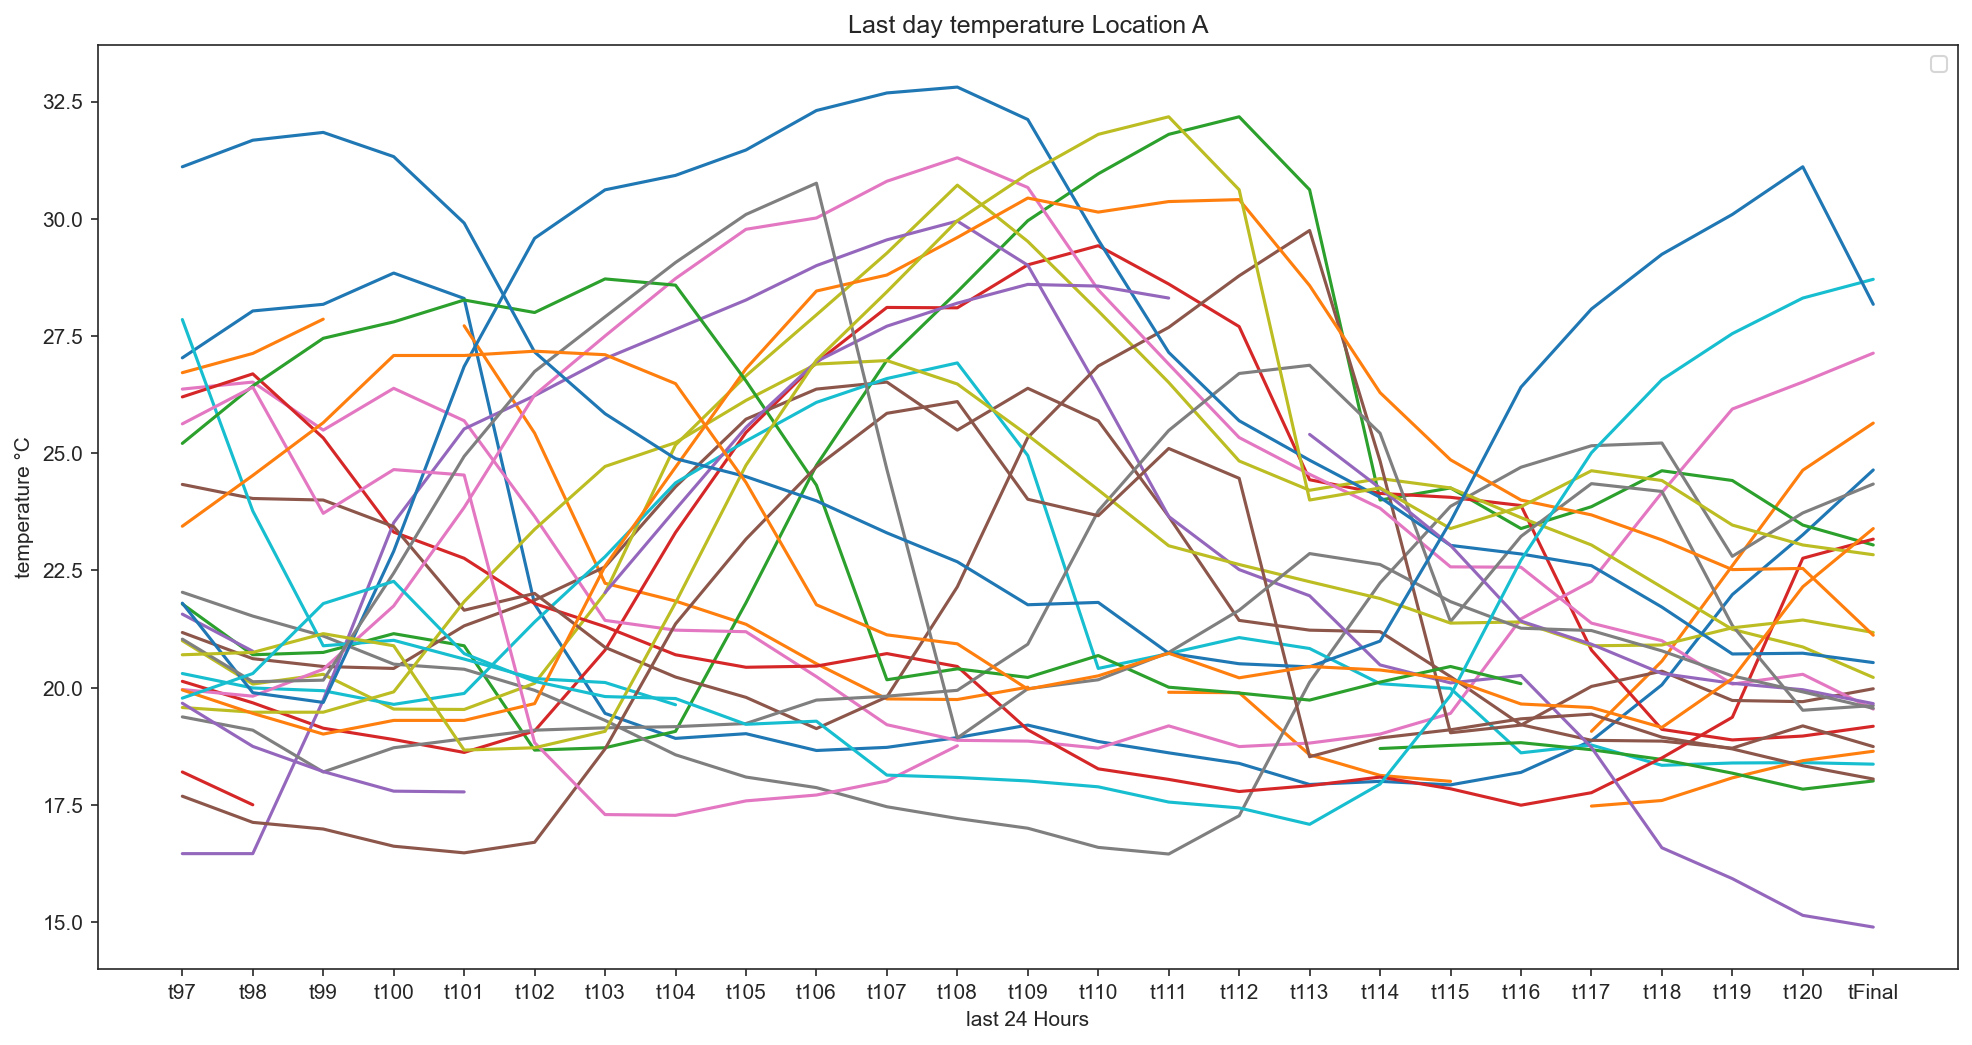

In [26]:
# perhaps is a more civilised way to plot it
plt.figure(figsize=(16,8), dpi =150)
plt.title('Last day temperature Location A')
plt.ylabel('temperature °C')
plt.xlabel('last 24 Hours')
# adding legend.
plt.legend()
plt.plot(df_trans_T24["A1"])
plt.plot(df_trans_T24["A2"])
plt.plot(df_trans_T24["A3"])
plt.plot(df_trans_T24["A4"])
plt.plot(df_trans_T24["A5"])
plt.plot(df_trans_T24["A6"])
plt.plot(df_trans_T24["A7"])
plt.plot(df_trans_T24["A8"])
plt.plot(df_trans_T24["A9"])
plt.plot(df_trans_T24["A10"])
plt.plot(df_trans_T24["A11"])
plt.plot(df_trans_T24["A12"])
plt.plot(df_trans_T24["A13"])
plt.plot(df_trans_T24["A14"])
plt.plot(df_trans_T24["A16"])
plt.plot(df_trans_T24["A17"])
plt.plot(df_trans_T24["A18"])
plt.plot(df_trans_T24["A19"])
plt.plot(df_trans_T24["A20"])
plt.plot(df_trans_T24["A21"])
plt.plot(df_trans_T24["A22"])
plt.plot(df_trans_T24["A23"])
plt.plot(df_trans_T24["A24"])
plt.plot(df_trans_T24["A25"])
plt.plot(df_trans_T24["A26"])
plt.plot(df_trans_T24["A27"])
plt.plot(df_trans_T24["A28"])
plt.plot(df_trans_T24["A29"])
plt.plot(df_trans_T24["A30"])
plt.plot(df_trans_T24["A31"])
plt.plot(df_trans_T24["A32"])
plt.plot(df_trans_T24["A33"])

I think it is not really possible to get the median of the whole week, but perhaps the median of the last hour? or the frecuency of las hour temperature, then the high frecuency perhaps is most probably to happen again in the next 24 hours.
so if it likehood, a naive regression model would be suitable. Doing same procedure for wind speed and the rest?

In [27]:
# "precip","rel_humidity","wind_dir","wind_spd","atmos_press"
df_wind_spd= data[["location", "wind_spd"]]
df_ws_121 = pd.DataFrame(columns=np.arange(121))
df_v=df_wind_spd.iloc[0:,1]
for i in df_v:
    df_ws_121.loc[len(df_ws_121)]=i
#concatenating the dataframes
tar=data['target']

df_121_Wstar= pd.concat([df_wind_spd,df_ws_121,tar],axis=1)
df_121_Wstar.drop('wind_spd',axis=1,inplace=True)

#sorting the values wind_sp for location
wssorted_data=df_121_Wstar.sort_values('location')
#Putting the names to the 121 hours

wssorted_data.columns= ["location", "ws1","ws2", "ws3","ws4", "ws5", "ws6", "ws7", "ws8", "ws9", "ws10", "ws11", "ws12", "ws13","ws14","ws15", "ws16",  "ws17",  "ws18",  "ws19",  "ws20",  "ws21",  "ws22",  "ws23",  "ws24",  "ws25",  "ws26",  "ws27",  "ws28",  "ws29",  "ws30",  "ws31",  "ws32",  "ws33",  "ws34",  "ws35",  "ws36",  "ws37",  "ws38",  "ws39",  "ws40",  "ws41",  "ws42",  "ws43",  "ws44",  "ws45",  "ws46",  "ws47",  "ws48",  "49",   "ws50",  "ws51",  "ws52",  "ws53",  "ws54",  "ws55",  "ws56",  "ws57",  "ws58",  "ws59",  "ws60",  "ws61",  "ws62",  "ws63",  "ws64",  "ws65",  "ws66",  "ws67",  "ws68",  "ws69",  "ws70",  "ws71",  "ws72",  "ws73",  "ws74",  "ws75",  "ws76",  "ws77",  "ws78",  "ws79",  "ws80",  "ws81",  "ws82",  "ws83",  "ws84",  "ws85",  "ws86",  "ws87",  "ws88",  "ws89",  "ws90",  "ws91",  "ws92",  "ws93",  "ws94",  "ws95",  "ws96",  "ws97",  "ws98",  "ws99",  "ws100", "ws101", "ws102", "ws103", "ws104", "ws105", "ws106", "ws107", "ws108", "ws109", "ws110", "ws111", "ws112", "ws113", "ws114", "ws115", "ws116", "ws117", "ws118", "ws119", "ws120", "wsFinal", "target"]

##droping location for plotting
wssorted_data.drop('location',axis=1,inplace=True)
# Transposing the data in order to plot per hour the temperature values
df_trans_Wstar= wssorted_data.T

#get the target, last column, out for now
df_trans_Ws=df_trans_Wstar.iloc[:121] 
df_trans_Ws.shape
#in df_trans_Ws last row is the target, need to drop it so that I could make a column of wind speed?
#adding a column name Wind speed
df_trans_Ws["hour_w"]= ["ws1","ws2", "ws3","ws4", "ws5", "ws6", "ws7", "ws8", "ws9", "ws10", "ws11", "ws12", "ws13","ws14","ws15","ws16","ws17","ws18","ws19",  "ws20",  "ws21",  "ws22",  "ws23",  "ws24",  "ws25",  "ws26",  "ws27",  "ws28",  "ws29",  "ws30",  "ws31",  "ws32",  "ws33",  "ws34",  "ws35",  "ws36",  "ws37",  "ws38",  "ws39",  "ws40",  "ws41",  "ws42",  "ws43",  "ws44",  "ws45",  "ws46",  "ws47",  "ws48",  "49",   "ws50",  "ws51",  "ws52",  "ws53",  "ws54",  "ws55",  "ws56",  "ws57",  "ws58",  "ws59",  "ws60",  "ws61",  "ws62",  "ws63",  "ws64",  "ws65",  "ws66",  "ws67",  "ws68",  "ws69",  "ws70",  "ws71",  "ws72",  "ws73",  "ws74",  "ws75",  "ws76",  "ws77",  "ws78",  "ws79",  "ws80",  "ws81",  "ws82",  "ws83",  "ws84",  "ws85",  "ws86",  "ws87",  "ws88",  "ws89",  "ws90",  "ws91",  "ws92",  "ws93",  "ws94",  "ws95",  "ws96",  "ws97",  "ws98",  "ws99",  "ws100", "ws101", "ws102", "ws103", "ws104", "ws105", "ws106", "ws107", "ws108", "ws109", "ws110", "ws111", "ws112", "ws113", "ws114", "ws115", "ws116", "ws117", "ws118", "ws119", "ws120", "wsFinal"]
#taken a slice of the df corresponding to the las 24 rows less target
df_trans_Ws24=df_trans_Ws.iloc[96:121] 
# list dataframe columns for temperature on last 24 hours and tendencies
df_trans_Ws24= df_trans_Ws24.iloc[: , :51]
#Putting the name of the location A column chosen
df_trans_Ws24.columns =["A1", "A2" , "A3","A4",  "A5",  "A6",  "A7",  "A8" , "A9" , "A10" , "A11" , "A12",  "A13" , "A14", "A15 ", "A16" , "A17"  ,"A18" , "A19" , "A20"  ,"A21"  ,"A22",  "A23" , "A24"  ,"A25",  "A26"  ,"A27" , "A28"  ,"A29" , "A30",  "A31",  "A32",  "A33" , "A34" , "A35" , "A36",  "A37" , "A38", "A39","A40" , "A41" , "A42",  "A43"  ,"A44" , "A45" , "A46"  ,"A47"  ,"A48" , "49" , "A50", "hour_w"]


/var/folders/3f/b_krqwq149sd6c_2sg6s0r580000gn/T/ipykernel_53794/4177815254.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trans_Ws["hour_w"]= ["ws1","ws2", "ws3","ws4", "ws5", "ws6", "ws7", "ws8", "ws9", "ws10", "ws11", "ws12", "ws13","ws14","ws15","ws16","ws17","ws18","ws19",  "ws20",  "ws21",  "ws22",  "ws23",  "ws24",  "ws25",  "ws26",  "ws27",  "ws28",  "ws29",  "ws30",  "ws31",  "ws32",  "ws33",  "ws34",  "ws35",  "ws36",  "ws37",  "ws38",  "ws39",  "ws40",  "ws41",  "ws42",  "ws43",  "ws44",  "ws45",  "ws46",  "ws47",  "ws48",  "49",   "ws50",  "ws51",  "ws52",  "ws53",  "ws54",  "ws55",  "ws56",  "ws57",  "ws58",  "ws59",  "ws60",  "ws61",  "ws62",  "ws63",  "ws64",  "ws65",  "ws66",  "ws67",  "ws68",  "ws69",  "ws70",  "ws71",  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


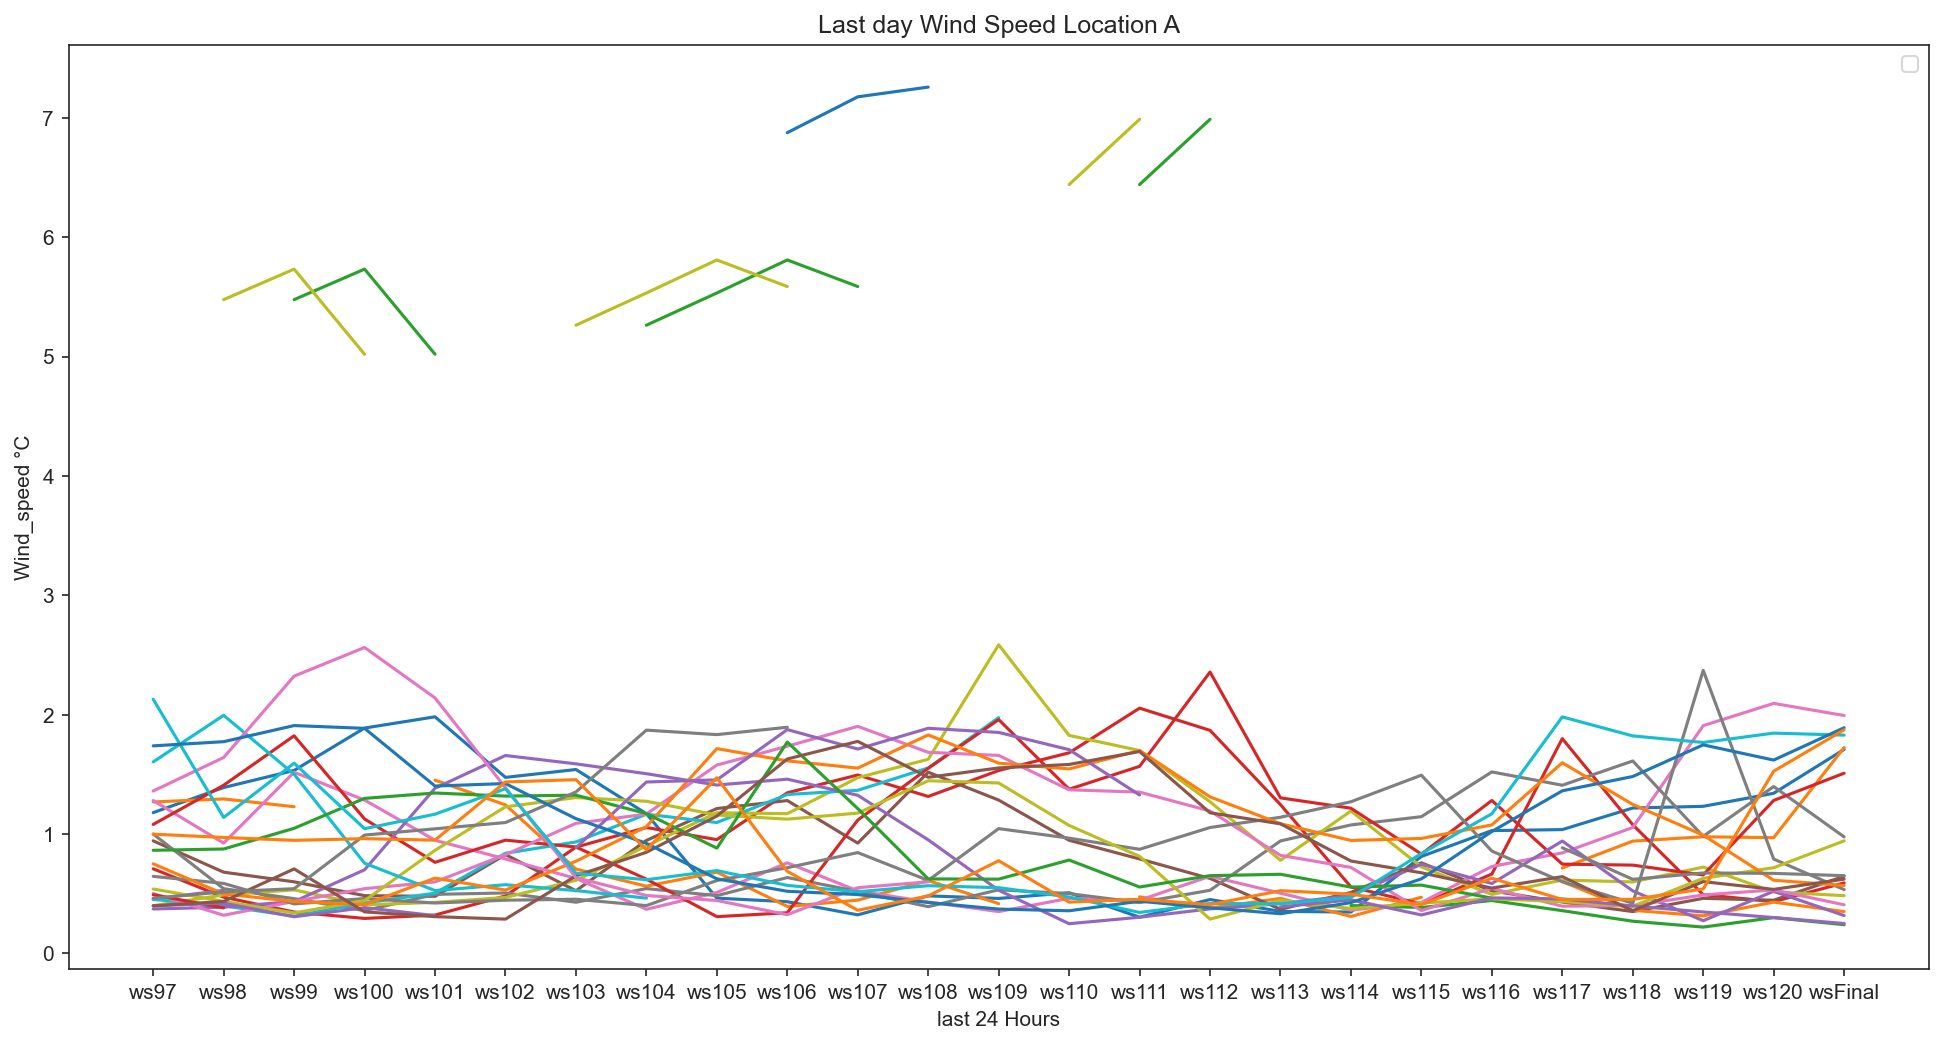

In [28]:
# perhaps is a more civilised way to plot it
plt.figure(figsize=(16,8), dpi =150)
plt.title('Last day Wind Speed Location A')
plt.ylabel('Wind_speed °C')
plt.xlabel('last 24 Hours')
# adding legend.
plt.legend()
plt.plot(df_trans_Ws24["A1"])
plt.plot(df_trans_Ws24["A2"])
plt.plot(df_trans_Ws24["A3"])
plt.plot(df_trans_Ws24["A4"])
plt.plot(df_trans_Ws24["A5"])
plt.plot(df_trans_Ws24["A6"])
plt.plot(df_trans_Ws24["A7"])
plt.plot(df_trans_Ws24["A8"])
plt.plot(df_trans_Ws24["A9"])
plt.plot(df_trans_Ws24["A10"])
plt.plot(df_trans_Ws24["A11"])
plt.plot(df_trans_Ws24["A12"])
plt.plot(df_trans_Ws24["A13"])
plt.plot(df_trans_Ws24["A14"])
plt.plot(df_trans_Ws24["A16"])
plt.plot(df_trans_Ws24["A17"])
plt.plot(df_trans_Ws24["A18"])
plt.plot(df_trans_Ws24["A19"])
plt.plot(df_trans_Ws24["A20"])
plt.plot(df_trans_Ws24["A21"])
plt.plot(df_trans_Ws24["A22"])
plt.plot(df_trans_Ws24["A23"])
plt.plot(df_trans_Ws24["A24"])
plt.plot(df_trans_Ws24["A25"])
plt.plot(df_trans_Ws24["A26"])
plt.plot(df_trans_Ws24["A27"])
plt.plot(df_trans_Ws24["A28"])
plt.plot(df_trans_Ws24["A29"])
plt.plot(df_trans_Ws24["A30"])
plt.plot(df_trans_Ws24["A31"])
plt.plot(df_trans_Ws24["A32"])
plt.plot(df_trans_Ws24["A33"])


In [29]:
#concatenate the column orderer from a df original before trans without forget to slice it to the frame of final
target=sorted_data["target"]
target_50=target.iloc[:50]
target_50.head()

12201    68.261905
3466     42.076977
6393     26.122500
3464     22.298864
3463     29.654286
Name: target, dtype: float64

In [30]:
data_f= df_trans_Ws24.T
data_f= pd.concat([data_f,target_50],axis=1)

In [31]:
data_f.tail()

,ws97,ws98,ws99,ws100,ws101,ws102,ws103,ws104,ws105,ws106,...,ws113,ws114,ws115,ws116,ws117,ws118,ws119,ws120,wsFinal,target
A6,0.942500,0.680000,0.599167,0.483333,0.477500,0.827500,0.524167,0.945833,1.213333,1.280000,...,0.369167,0.510000,0.758333,0.523333,0.430000,0.350000,0.460833,0.445000,0.645833,NaN
A7,1.280000,0.923333,1.517500,1.284167,0.947500,0.790833,0.627500,0.369167,0.510000,0.758333,...,0.504167,0.361667,0.426667,0.727500,0.841667,1.054167,1.907500,2.094167,1.992500,NaN
A8,0.999167,0.541667,0.458333,0.357500,0.494167,0.505833,0.428333,0.542500,0.483333,0.635000,...,0.941667,1.075833,1.145000,1.520000,1.408333,1.611667,0.980000,1.397500,0.975833,NaN
A9,0.399167,0.489167,0.531667,0.406667,0.426667,0.468333,0.611667,0.900000,1.178333,1.170000,...,0.780000,1.192500,0.724167,0.493333,0.614167,0.598333,0.722500,0.515000,0.483333,NaN
hour_w,0.962500,1.075833,1.596667,1.247500,0.990000,0.612500,0.568333,0.439167,0.495833,0.335000,...,1.256667,1.325000,1.441667,2.550833,1.466667,0.974167,0.715000,0.522500,0.915000,NaN


[Text(0.5, 1.0, 'Wind vs Target last 24 hours')]

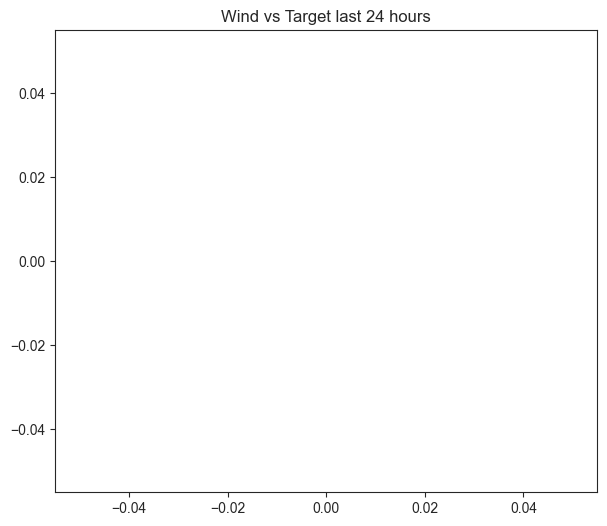

In [32]:
# Scattplot which doesnt show the wave variation I was expecting
sns.scatterplot(x=data_f.wsFinal, y=data_f.target, color='#33658A').set(title='Wind vs Target last 24 hours')

### _Precipitation incidence in pollution (target)_

In [33]:
# "precip","rel_humidity","wind_dir","wind_spd","atmos_press"
df_precip= data[["location", "precip"]]
df_precip_121 = pd.DataFrame(columns=np.arange(121))
df_v=df_precip.iloc[0:,1]
for i in df_v:
    df_precip_121.loc[len(df_precip_121)]=i
#concatenating the dataframes
ptar=data['target']
df_121_preciptar= pd.concat([df_precip,df_precip_121,tar],axis=1)
df_121_preciptar.drop('precip',axis=1,inplace=True)

#sorting the values wind_sp for location
precipsorted_data=df_121_preciptar.sort_values('location')
#Putting the names to the 121 hours

precipsorted_data.columns= ["location","precip1","precip2", "precip3","precip4", "precip5", "precip6", "precip7", "precip8", "precip9", "precip10", "precip11", "precip12", "precip13","precip14","precip15", "precip16",  "precip17",  "precip18",  "precip19",  "precip20",  "precip21",  "precip22",  "precip23",  "precip24",  "precip25",  "precip26",  "precip27",  "precip28",  "precip29",  "precip30",  "precip31",  "precip32",  "precip33",  "precip34",  "precip35",  "precip36",  "precip37",  "precip38",  "precip39",  "precip40",  "precip41",  "precip42",  "precip43",  "precip44",  "precip45",  "precip46",  "precip47",  "precip48",  "49",   "precip50",  "precip51",  "precip52",  "precip53",  "precip54",  "precip55",  "precip56",  "precip57",  "precip58",  "precip59",  "precip60",  "precip61",  "precip62",  "precip63",  "precip64",  "precip65",  "precip66",  "precip67",  "precip68",  "precip69",  "precip70",  "precip71",  "precip72",  "precip73",  "precip74",  "precip75",  "precip76",  "precip77",  "precip78",  "precip79",  "precip80",  "precip81",  "precip82",  "precip83",  "precip84",  "precip85",  "precip86",  "precip87",  "precip88",  "precip89",  "precip90",  "precip91",  "precip92",  "precip93",  "precip94",  "precip95",  "precip96",  "precip97",  "precip98",  "precip99",  "precip100", "precip101", "precip102", "precip103", "precip104", "precip105", "precip106", "precip107", "precip108", "precip109", "precip110", "precip111", "precip112", "precip113", "precip114", "precip115", "precip116", "precip117", "precip118", "precip119", "precip120", "precipFinal", "target"]
##dropping location for plotting
precipsorted_data.drop('location',axis=1,inplace=True)
# 

### _rel_humidity incidence in pollution (target)_

In [34]:
# "precip","rel_humidity","wind_dir","wind_spd","atmos_press"
df_feu= data[["location", "precip"]]
df_feu_121 = pd.DataFrame(columns=np.arange(121))
df_v=df_feu.iloc[0:,1]
for i in df_v:
    df_feu_121.loc[len(df_feu_121)]=i
#concatenating the dataframes
feutar=data['target']
df_121_feutar= pd.concat([df_feu,df_feu_121,feutar],axis=1)
df_121_feutar.drop('precip',axis=1,inplace=True)

#sorting the values wind_sp for location
feusorted_data=df_121_feutar.sort_values('location')
#Putting the names to the 121 hours

feusorted_data.columns= ["location","feu1","feu2", "feu3","feu4", "feu5", "feu6", "feu7", "feu8", "feu9", "feu10", "feu11", "feu12", "feu13","feu14","feu15", "feu16",  "feu17",  "feu18",  "feu19",  "feu20",  "feu21",  "feu22",  "feu23",  "feu24",  "feu25",  "feu26",  "feu27",  "feu28",  "feu29",  "feu30",  "feu31",  "feu32",  "feu33",  "feu34",  "feu35",  "feu36",  "feu37",  "feu38",  "feu39",  "feu40",  "feu41",  "feu42",  "feu43",  "feu44",  "feu45",  "feu46",  "feu47",  "feu48",  "49",   "feu50",  "feu51",  "feu52",  "feu53",  "feu54",  "feu55",  "feu56",  "feu57",  "feu58",  "feu59",  "feu60",  "feu61",  "feu62",  "feu63",  "feu64",  "feu65",  "feu66",  "feu67",  "feu68",  "feu69",  "feu70",  "feu71",  "feu72",  "feu73",  "feu74",  "feu75",  "feu76",  "feu77",  "feu78",  "feu79",  "feu80",  "feu81",  "feu82",  "feu83",  "feu84",  "feu85",  "feu86",  "feu87",  "feu88",  "feu89",  "feu90",  "feu91",  "feu92",  "feu93",  "feu94",  "feu95",  "feu96",  "feu97",  "feu98",  "feu99",  "feu100", "feu101", "feu102", "feu103", "feu104", "feu105", "feu106", "feu107", "feu108", "feu109", "feu110", "feu111", "feu112", "feu113", "feu114", "feu115", "feu116", "feu117", "feu118", "feu119", "feu120", "feuFinal", "target"]
##dropping location for plotting
feusorted_data.drop('location',axis=1,inplace=True)

### _wind_dir incidence in pollution (target)_

In [35]:
# "precip","rel_humidity","wind_dir","wind_spd","atmos_press"
df_wd= data[["location", "wind_dir"]]
df_wd_121 = pd.DataFrame(columns=np.arange(121))
df_v=df_wd.iloc[0:,1]
for i in df_v:
    df_wd_121.loc[len(df_wd_121)]=i
#concatenating the dataframes
wdtar=data['target']
df_121_wdtar= pd.concat([df_wd,df_wd_121,wdtar],axis=1)
df_121_wdtar.drop('wind_dir',axis=1,inplace=True)

#sorting the values wind_sp for location
wdsorted_data=df_121_wdtar.sort_values('location')
#Putting the names to the 121 hours

wdsorted_data.columns= ["location","feu1","feu2", "feu3","feu4", "feu5", "feu6", "feu7", "feu8", "feu9", "feu10", "feu11", "feu12", "feu13","feu14","feu15", "feu16",  "feu17",  "feu18",  "feu19",  "feu20",  "feu21",  "feu22",  "feu23",  "feu24",  "feu25",  "feu26",  "feu27",  "feu28",  "feu29",  "feu30",  "feu31",  "feu32",  "feu33",  "feu34",  "feu35",  "feu36",  "feu37",  "feu38",  "feu39",  "feu40",  "feu41",  "feu42",  "feu43",  "feu44",  "feu45",  "feu46",  "feu47",  "feu48",  "49",   "feu50",  "feu51",  "feu52",  "feu53",  "feu54",  "feu55",  "feu56",  "feu57",  "feu58",  "feu59",  "feu60",  "feu61",  "feu62",  "feu63",  "feu64",  "feu65",  "feu66",  "feu67",  "feu68",  "feu69",  "feu70",  "feu71",  "feu72",  "feu73",  "feu74",  "feu75",  "feu76",  "feu77",  "feu78",  "feu79",  "feu80",  "feu81",  "feu82",  "feu83",  "feu84",  "feu85",  "feu86",  "feu87",  "feu88",  "feu89",  "feu90",  "feu91",  "feu92",  "feu93",  "feu94",  "feu95",  "feu96",  "feu97",  "feu98",  "feu99",  "feu100", "feu101", "feu102", "feu103", "feu104", "feu105", "feu106", "feu107", "feu108", "feu109", "feu110", "feu111", "feu112", "feu113", "feu114", "feu115", "feu116", "feu117", "feu118", "feu119", "feu120", "feuFinal", "target"]
##dropping location for plotting
wdsorted_data.drop('location',axis=1,inplace=True)

In [36]:
#wdtar=data['target'] no organised, that is perfect cause just want to know the average target in each location
wdtar.columns

AttributeError: 'Series' object has no attribute 'columns'

 ### _atmos_press incidence in pollution (target)_

In [ ]:
# "precip","rel_humidity","wind_dir","wind_spd","atmos_press"
df_atm= data[["location", "wind_dir"]]
df_atm_121 = pd.DataFrame(columns=np.arange(121))
df_v=df_atm.iloc[0:,1]
for i in df_v:
    df_atm_121.loc[len(df_atm_121)]=i
#concatenating the dataframes
atmtar=data['target']
df_121_atmtar= pd.concat([df_atm,df_atm_121,atmtar],axis=1)
df_121_atmtar.drop('atmos_press',axis=1,inplace=True)

#sorting the values wind_sp for location
atmsorted_data=df_121_atmtar.sort_values('location')
#Putting the names to the 121 hours

atmsorted_data.columns= ["location","atm1","atm2", "atm3","atm4", "atm5", "atm6", "atm7", "atm8", "atm9", "atm10", "atm11", "atm12", "atm13","atm14","atm15", "atm16",  "atm17",  "atm18",  "atm19",  "atm20",  "atm21",  "atm22",  "atm23",  "atm24",  "atm25",  "atm26",  "atm27",  "atm28",  "atm29",  "atm30",  "atm31",  "atm32",  "atm33",  "atm34",  "atm35",  "atm36",  "atm37",  "atm38",  "atm39",  "atm40",  "atm41",  "atm42",  "atm43",  "atm44",  "atm45",  "atm46",  "atm47",  "atm48",  "49",   "atm50",  "atm51",  "atm52",  "atm53",  "atm54",  "atm55",  "atm56",  "atm57",  "atm58",  "atm59",  "atm60",  "atm61",  "atm62",  "atm63",  "atm64",  "atm65",  "atm66",  "atm67",  "atm68",  "atm69",  "atm70",  "atm71",  "atm72",  "atm73",  "atm74",  "atm75",  "atm76",  "atm77",  "atm78",  "atm79",  "atm80",  "atm81",  "atm82",  "atm83",  "atm84",  "atm85",  "atm86",  "atm87",  "atm88",  "atm89",  "atm90",  "atm91",  "atm92",  "atm93",  "atm94",  "atm95",  "atm96",  "atm97",  "atm98",  "atm99",  "atm100", "atm101", "atm102", "atm103", "atm104", "atm105", "atm106", "atm107", "atm108", "atm109", "atm110", "atm111", "atm112", "atm113", "atm114", "atm115", "atm116", "atm117", "atm118", "atm119", "atm120", "atmFinal", "target"]
##dropping location for plotting
atmsorted_data.drop('location',axis=1,inplace=True)

KeyError: "['atmos_press'] not found in axis"

In [ ]:
atmsorted_data.head()

In [ ]:
data.columns.tolist()
 #aggregation function extracting summary statistics from every recording period and appending it as a new column to a dataframe
def aggregate_dff_temp(x,col_name):
    x["max_"+col_name]=x[col_name].apply(np.max)
    x["min_"+col_name]=x[col_name].apply(np.min)
    x["mean_"+col_name]=x[col_name].apply(np.mean)
    x["std_"+col_name]=x[col_name].apply(np.std)
    x["var_"+col_name]=x[col_name].apply(np.var)
    x["median_"+col_name]=x[col_name].apply(np.median)
    x["ptp_"+col_name]=x[col_name].apply(np.ptp)
    return x  

ValueError: Could not interpret value `target` for parameter `y`

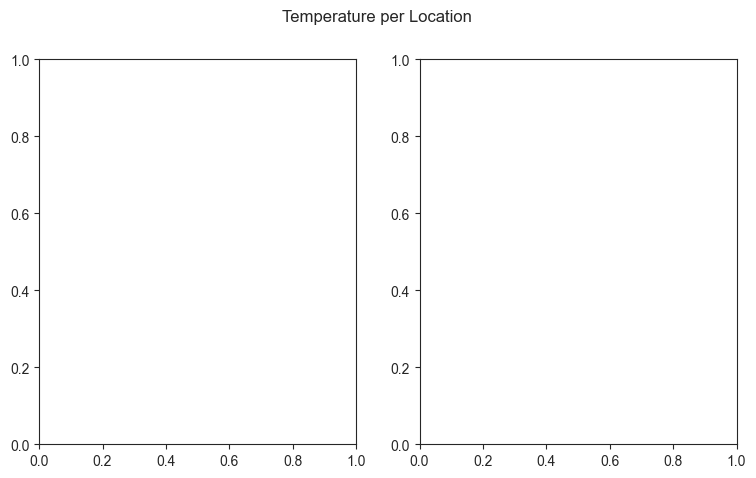

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
plt.suptitle('Temperature per Location')

plot1 = sns.scatterplot(data=df_temp, x='temp', y='target', hue='location', ax=ax1, hue_order=['A', 'B', 'C', 'D', 'E'])
plot1.set_title('non_filtered')

plot2 = sns.scatterplot(data=df_temp, x='temp', y='target', hue='location', ax=ax2, hue_order=['A', 'B', 'C', 'D', 'E'])
plot2.set_title('non_filtered')

plt.tight_layout()

In [ ]:
df_temp['percent_nan'] = data.temp.apply(lambda x: np.isnan(np.array(x)).sum()/len(x)*100)

In [ ]:
df_temp.head()

In [ ]:
# recording periods contain varying degrees of NaNs: compute percent NaN for each recording period and feature
# function to compute the percentage of NaNs per recording period
def compute_percent_nan(df, col_name):
    df['percent_nan_'+col_name] = df[col_name].apply(lambda x: np.isnan(np.array(x)).sum()/len(x)*100)
    return df

In [ ]:
# calculate percentage of missings per recording period and feature and append to dataframe
for col_name in tqdm(features):
    data=compute_percent_nan(data,col_name)

In [ ]:
data.head(2)

In [ ]:
data.columns.tolist()

In [ ]:
# aggregation function extracting summary statistics from every recording period and appending it as a new column to a dataframe
def aggregate_features(x,col_name):
    x["max_"+col_name]=x[col_name].apply(np.max)
    x["min_"+col_name]=x[col_name].apply(np.min)
    x["mean_"+col_name]=x[col_name].apply(np.mean)
    x["std_"+col_name]=x[col_name].apply(np.std)
    x["var_"+col_name]=x[col_name].apply(np.var)
    x["median_"+col_name]=x[col_name].apply(np.median)
    x["ptp_"+col_name]=x[col_name].apply(np.ptp)
    return x  

# function returning only non-Null values (helper for aggregation function)
def remove_nan_values(x):
    return [e for e in x if not math.isnan(e)]


In [ ]:
# remove NaNs from dataframe
for col_name in tqdm(features):
   data[col_name]=data[col_name].apply(remove_nan_values)

In [ ]:
data.head()

In [ ]:
#extract summary statistics for each recording period and feature
for col_name in tqdm(features):
    data=aggregate_features(data,col_name)

In [ ]:
data.head()

In [ ]:
# extract all single raw values from each feature and append them as new columns to the dataframe
for x in range(121):
    data["newtemp"+ str(x)] = data.temp.str[x]
    data["newprecip"+ str(x)] = data.precip.str[x]
    data["newrel_humidity"+ str(x)] = data.rel_humidity.str[x]
    data["newwind_dir"+ str(x)] = data.wind_dir.str[x]
    data["windspeed"+ str(x)] = data.wind_spd.str[x]
    data["atmospherepressure"+ str(x)] = data.atmos_press.str[x]

In [ ]:
# drop raw sensor data contained as list from the initial dataset
data.drop(features,1,inplace=True)

In [ ]:
data.head(2)

### Exploratory data analysis

In [ ]:
# list dataframe columns for target and condensed features, including percent NaNs
summary_columns = data.columns[:51]
summary_columns

In [ ]:
# select data with summary statistics for the different features
df_condensed = data[summary_columns]
df_condensed.set_index('ID', drop=True, inplace=True)
df_condensed.head(2)

In [ ]:
df_condensed.columns

In [ ]:
# plot pairplot to examine feature-wise correlations I would like to group by max_temp so that the plots would be compared only at max_temp
sns.pairplot(df_condensed[['location', 'max_temp', 'mean_wind_spd', 'mean_atmos_press','mean_rel_humidity', 'target']], hue='location');

In [ ]:
# plot pairplot to examine feature-wise correlations I would like to group by max_temp so that the plots would be compared only at max_temp
sns.pairplot(df_condensed[['location', 'max_temp', 'mean_temp','mean_wind_spd', 'mean_atmos_press','mean_rel_humidity', 'target']], hue='max_temp');

In [ ]:
# condensed data for samples on each location, which we can not really condensate but look at the whole range first.
sns.scatterplot(data = df_condensed, x = "mean_wind_spd", y = "target",  hue='location')

In [ ]:
# condensed data for samples on each location, which we can not really condensate but look at the whole range first.
sns.scatterplot(data = df_condensed, x = "mean_wind_spd", y = "target",  hue='location')

In [ ]:
sns.scatterplot(data = df_condensed, x = "max_wind_dir", y = "target",  hue='location')

In [ ]:
sns.scatterplot(data = df_condensed, x = "max_wind_dir", y = "target",  hue='max_temp')

In [ ]:
# Plotting one feature with histogram, boxplot and scatterplot
fig,ax = plt.subplots(nrows=4,figsize=(12,16))
count = 0
# Histogram
sns.histplot(df_condensed['max_wind_spd'], kde=True, ax=ax[0], color='#33658A').set(title='max_wind_spd', xlabel='')
# Boxplot
sns.boxplot(x= df_condensed['max_wind_spd'],ax=ax[1], color='#33658A').set(title='max_wind_spd')
# Scattplot
sns.scatterplot(x=df_condensed.max_wind_spd, y=df_condensed.target,ax=ax[2], color='#33658A').set(title='max_wind_spd')
   
ax.flat[-1].set_visible(False)
fig.tight_layout(pad=3)



In [ ]:
# Plotting one feature with histogram, boxplot and scatterplot
fig,ax = plt.subplots(nrows=4,figsize=(12,16))
count = 0
# Histogram
sns.histplot(df_condensed['min_rel_humidity'], kde=True, ax=ax[0], color='#33658A').set(title='min_rel_humidity', xlabel='')
# Boxplot
sns.boxplot(x= df_condensed['min_rel_humidity'],ax=ax[1], color='#33658A').set(title='min_rel_humidity')
# Scattplot
sns.scatterplot(x=df_condensed.min_rel_humidity, y=df_condensed.target,ax=ax[2], color='#33658A').set(title='min_rel_humidity')
   
ax.flat[-1].set_visible(False)
fig.tight_layout(pad=3)


In [ ]:
# Plotting one feature with histogram, boxplot and scatterplot
fig,ax = plt.subplots(nrows=4,figsize=(12,16))
count = 0
# Histogram
sns.histplot(df_condensed['max_wind_dir'], kde=True, ax=ax[0], color='#33658A').set(title='max_wind_dir', xlabel='')
# Boxplot
sns.boxplot(x= df_condensed['max_wind_dir'],ax=ax[1], color='#33658A').set(title='max_wind_dir')
# Scattplot
sns.scatterplot(x=df_condensed.max_wind_dir, y=df_condensed.target,ax=ax[2], color='#33658A').set(title='max_wind_dir')
   
ax.flat[-1].set_visible(False)
fig.tight_layout(pad=3)


### Compute basic summary statistics

In [ ]:
df_condensed.info()

In [ ]:
# get descriptive statistics on the percentage of NaNs for the recording period
df_condensed[['percent_nan_temp', 'percent_nan_precip',
       'percent_nan_rel_humidity', 'percent_nan_wind_dir',
       'percent_nan_wind_spd', 'percent_nan_atmos_press']].describe().round(2)

### Distribution and correlations of percent NaNs between features

In [ ]:
# check the overall distribution of percent NaNs depending on sensor location using histograms

nan_columns = ['percent_nan_temp', 'percent_nan_precip','percent_nan_rel_humidity', 'percent_nan_wind_dir','percent_nan_wind_spd', 
        'percent_nan_atmos_press']

fig = plt.figure(figsize=(15, 20))

for i in range(1, len(nan_columns)+1): # start with i=1 (0th subplot is not possible)
    ax = fig.add_subplot(4, 2, i) # arrange figure as rows = 6 x cols = 4 panel and add ith subplot
    subplot = sns.histplot(x=nan_columns[i-1], hue='location', bins=20, data=df_condensed)
    ax.set_xlabel(nan_columns[i-1])

fig.tight_layout() # prevents subplots from overlapping

In [ ]:
# plot pairplot to examine feature-wise correlations in the percent NaNs
sns.pairplot(df_condensed[['location', 'percent_nan_temp', 'percent_nan_precip','percent_nan_rel_humidity', 'percent_nan_wind_dir','percent_nan_wind_spd', 
        'percent_nan_atmos_press']], hue='location');

### Filter dataframe for observations with percent NaN < 30% for all features

In [ ]:
# filter observations based on percent NaN and check again the data distribution of the target and summary features
df_filtered = df_condensed[(df_condensed[nan_columns]<30).all(axis=1)]
df_filtered.head()

In [ ]:
percent_reduc = (df_condensed.shape[0]-df_filtered.shape[0]) / df_condensed.shape[0]*100
print(f'Percent reduction in dataset size after filtering: {round(percent_reduc,1)}%')

### Data distribution for the summary features and target

In [ ]:
# get target and summary feature columns
colnames = df_condensed.columns.to_list()[1::] # get columns w/o location column
del colnames[1:8] # delete columns containing data on percent NaN
colnames

In [ ]:
# plot histograms on the distribution of the other data
fig = plt.figure(figsize=(15, 20))

for i in range(1, len(colnames)+1): # start with i=1 (0th subplot is not possible)
    ax = fig.add_subplot(9, 5, i) # arrange figure as rows = 6 x cols = 4 panel and add ith subplot
    subplot = sns.histplot(x=colnames[i-1], hue='location', data=df_condensed)
    ax.set_xlabel(colnames[i-1])

fig.tight_layout() # prevents subplots from overlapping

### Mean differences in air pollution between locations for filtered and unfiltered data

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
plt.suptitle('Air pollution depending on sensor location')

plot1 = sns.boxplot(data=df_condensed, x='location', y='target', ax=ax1, order=['A', 'B', 'C', 'D', 'E'])
ax1.set_title('unfiltered')
ax1.set_ylabel('PM2.5 (ug/m^3')
ax1.set_xlabel('Sensor location')

plot2 = sns.boxplot(data=df_filtered, x='location', y='target', ax=ax2, order=['A', 'B', 'C', 'D', 'E'])
ax2.set_title('filtered')
ax2.set_ylabel('PM2.5 (ug/m^3)')
ax2.set_xlabel('Sensor location')

plt.tight_layout();

### Correlations between mean values for features and target for unfiltered and filtered data

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
plt.suptitle('Relationship between mean temperature and PM2.5')

plot1 = sns.scatterplot(data=df_condensed, x='mean_temp', y='target', hue='location', ax=ax1, hue_order=['A', 'B', 'C', 'D', 'E'])
plot1.set_title('unfiltered')

plot2 = sns.scatterplot(data=df_filtered, x='mean_temp', y='target', hue='location', ax=ax2, hue_order=['A', 'B', 'C', 'D', 'E'])
plot2.set_title('filtered')

plt.tight_layout()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
plt.suptitle('Relationship between mean precipitation and PM2.5')

plot1 = sns.scatterplot(data=df_condensed, x='mean_precip', y='target', hue='location', ax=ax1, hue_order=['A', 'B', 'C', 'D', 'E'])
plot1.set_title('unfiltered')

plot2 = sns.scatterplot(data=df_filtered, x='mean_precip', y='target', hue='location', ax=ax2, hue_order=['A', 'B', 'C', 'D', 'E'])
plot2.set_title('filtered')

plt.tight_layout()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
plt.suptitle('Relationship between mean humidity and PM2.5')

plot1 = sns.scatterplot(data=df_condensed, x='mean_rel_humidity', y='target', hue='location', ax=ax1, hue_order=['A', 'B', 'C', 'D', 'E'])
plot1.set_title('unfiltered')

plot2 = sns.scatterplot(data=df_filtered, x='mean_rel_humidity', y='target', hue='location', ax=ax2, hue_order=['A', 'B', 'C', 'D', 'E'])
plot2.set_title('filtered')

plt.tight_layout()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
plt.suptitle('Relationship between mean wind direction and PM2.5')

plot1 = sns.scatterplot(data=df_condensed, x='mean_wind_dir', y='target', hue='location', ax=ax1, hue_order=['A', 'B', 'C', 'D', 'E'])
plot1.set_title('unfiltered')

plot2 = sns.scatterplot(data=df_filtered, x='mean_wind_dir', y='target', hue='location', ax=ax2, hue_order=['A', 'B', 'C', 'D', 'E'])
plot2.set_title('filtered')

plt.tight_layout()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
plt.suptitle('Relationship between mean wind speed and PM2.5')

plot1 = sns.scatterplot(data=df_condensed, x='mean_wind_spd', y='target', hue='location', ax=ax1, hue_order=['A', 'B', 'C', 'D', 'E'])
plot1.set_title('unfiltered')

plot2 = sns.scatterplot(data=df_filtered, x='mean_wind_spd', y='target', hue='location', ax=ax2, hue_order=['A', 'B', 'C', 'D', 'E'])
plot2.set_title('filtered')

plt.tight_layout()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
plt.suptitle('Relationship between mean atmospheric pressure and PM2.5')

plot1 = sns.scatterplot(data=df_condensed, x='mean_atmos_press', y='target', hue='location', ax=ax1, hue_order=['A', 'B', 'C', 'D', 'E'])
plot1.set_title('unfiltered')

plot2 = sns.scatterplot(data=df_filtered, x='mean_atmos_press', y='target', hue='location', ax=ax2, hue_order=['A', 'B', 'C', 'D', 'E'])
plot2.set_title('filtered')

plt.tight_layout()

### Calculate the basemodel
We compute a baseline model, predicting the target using the mean values of the different features.

In [ ]:
# import libraries and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
# get target and features
X = df_condensed[['location', 'mean_temp', 'mean_precip', 'mean_rel_humidity', 'mean_wind_dir', 'mean_wind_spd', 'mean_atmos_press']]
y = df_condensed.target

print(X.shape)
print(y.shape)

In [ ]:
# perform train test split, stratified by location in order to ensure that locations are balanced between training and test set
rseed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=X['location'], random_state=rseed)

print(X_train.shape)
print(X_test.shape)

In [ ]:
# scale features using z-transformation
scaler = StandardScaler()

# fit_transform training data, drop location column since it will not be used for prediction
X_train_scaled = scaler.fit_transform(X_train.drop('location', axis=1))
# aply transform to test data
X_test_scaled = scaler.transform(X_test.drop('location', axis=1))

In [ ]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

In [ ]:
# check if transformation worked

# calculate mean
print('Means')
for i in range(X_train_scaled.shape[1]):
    print(X_train_scaled[:, i].mean().round(2))

print('\nStandard deviations:')
# calculate standard deviation
for i in range(X_train_scaled.shape[1]):
    print(X_train_scaled[:, i].std().round(2))

In [ ]:
# train the model
linreg = LinearRegression()

linreg.fit(X_train_scaled, y_train)

In [ ]:
# get beta coefficients
linreg.coef_

In [ ]:
# predict new cases
y_pred = linreg.predict(X_test_scaled)

# show first 10 predictions
y_pred[:10]

In [ ]:
# evaluate model accurray

rmse_linreg = mean_squared_error(y_test, y_pred, squared=False)
r2_linreg = r2_score(y_test, y_pred)

print(f'RMSE on testset: {round(rmse_linreg,2)}')
print(f'Coefficient of determination on testset: {round(r2_linreg,2)}')

### Calculate baseline model only for location B 
We re-perform our linear regression only using sensor data for location B, because the data for this location seem to be most representative of the whole data, without risking our model training being confounded by location-specific data due to the hierarchical data structure.

In [ ]:
# extract data only for location B
df_locB = df_condensed[df_condensed.location == 'B']
df_locB.head()

In [ ]:
df_locB.shape

In [ ]:
# get target and features
X_locB = df_locB[['location', 'mean_temp', 'mean_precip', 'mean_rel_humidity', 'mean_wind_dir', 'mean_wind_spd', 'mean_atmos_press']]
y_locB = df_locB.target

In [ ]:
# perform train test split, stratification not needed anymore
rseed = 42

X_train_locB, X_test_locB, y_train_locB, y_test_locB = train_test_split(X_locB, y_locB, test_size=0.3, random_state=rseed)

print(X_train_locB.shape)
print(X_test_locB.shape)

In [ ]:
# scale features using z-transformation
scaler_locB = StandardScaler()

# fit_transform training data, drop location column since it will not be used for prediction
X_train_scaled_locB = scaler.fit_transform(X_train_locB.drop('location', axis=1))
# aply transform to test data
X_test_scaled_locB = scaler.transform(X_test_locB.drop('location', axis=1))

In [ ]:
# train the model
linreg_locB = LinearRegression()

linreg_locB.fit(X_train_scaled_locB, y_train_locB)

In [ ]:
# get beta coefficients
linreg_locB.coef_

In [ ]:
# predict new cases
y_pred_locB = linreg.predict(X_test_scaled_locB)

# show first 10 predictions
y_pred_locB[:10]

In [ ]:
# evaluate model accurray

rmse_linreg_locB = mean_squared_error(y_test_locB, y_pred_locB, squared=False)
r2_linreg_locB = r2_score(y_test_locB, y_pred_locB)

print(f'RMSE on testset: {round(rmse_linreg_locB,2)}')
print(f'Coefficient of determination on testset: {round(r2_linreg_locB,2)}')

### Calculate baseline model with filtered data

In [ ]:
# get target and features
X_filtered = df_filtered[['location', 'mean_temp', 'mean_precip', 'mean_rel_humidity', 'mean_wind_dir', 'mean_wind_spd', 'mean_atmos_press']]
y_filtered = df_filtered.target

In [ ]:
# perform train test split, stratify according to sensor location
rseed = 42

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_filtered, y_filtered, test_size=0.3, 
                                            stratify=X_filtered['location'], random_state=rseed)

print(X_train_f.shape)
print(X_test_f.shape)

In [ ]:
# scale features using z-transformation
scaler_f = StandardScaler()

# fit_transform training data, drop location column since it will not be used for prediction
X_train_scaled_f = scaler.fit_transform(X_train_f.drop('location', axis=1))
# aply transform to test data
X_test_scaled_f = scaler.transform(X_test_f.drop('location', axis=1))

In [ ]:
# train the model
linreg_f = LinearRegression()

linreg_f.fit(X_train_scaled_f, y_train_f)

In [ ]:
# get beta coefficients
linreg_f.coef_

In [ ]:
# predict new cases
y_pred_f = linreg.predict(X_test_scaled_f)

# show first 10 predictions
y_pred_f[:10]

In [ ]:
# evaluate model accurray

rmse_linreg_f = mean_squared_error(y_test_f, y_pred_f, squared=False)
r2_linreg_f = r2_score(y_test_f, y_pred_f)

print(f'RMSE on testset: {round(rmse_linreg_f,2)}')
print(f'Coefficient of determination on testset: {round(r2_linreg_f,2)}')

### Residual plot for baseline model trained on filtered data

In [ ]:
# calculate residuals
residual = y_test_f - y_pred_f

# compute mean of residuals
np.mean(residual)

Thus, on average, our baseline model rather seems to underestimate the air pollution, as indicated by an average residual error > 0.

In [ ]:
sns.scatterplot(x=y_pred_f, y=residual, hue=X_test_f['location'])
plt.xlabel('y_pred')
plt.ylabel('residual')
plt.title('Residual plot');

In [ ]:
sns.scatterplot(x=X_test_f.mean_temp, y=residual, hue=X_test_f['location'])
plt.xlabel('mean temperature')
plt.ylabel('residual')
plt.title('Residual plot');

In [ ]:
sns.scatterplot(x=X_test_f.mean_precip, y=residual, hue=X_test_f['location'])
plt.xlabel('mean precipitation')
plt.ylabel('residual')
plt.title('Residual plot');

In [ ]:
sns.scatterplot(x=X_test_f.mean_rel_humidity, y=residual, hue=X_test_f['location'])
plt.xlabel('mean relative humidity')
plt.ylabel('residual')
plt.title('Residual plot');

In [ ]:
sns.scatterplot(x=X_test_f.mean_wind_dir, y=residual, hue=X_test_f['location'])
plt.xlabel('mean wind direction')
plt.ylabel('residual')
plt.title('Residual plot');

In [ ]:
sns.scatterplot(x=X_test_f.mean_wind_spd, y=residual, hue=X_test_f['location'])
plt.xlabel('mean wind speed')
plt.ylabel('residual')
plt.title('Residual plot');

In [ ]:
sns.scatterplot(x=X_test_f.mean_atmos_press, y=residual, hue=X_test_f['location'])
plt.xlabel('mean atmospheric pressure')
plt.ylabel('residual')
plt.title('Residual plot');

### Conclusion
The data has a different hierarchical, i.e. nested structure, with measurements being nested within defined sensor locations. This makes the dataset difficult to handle.


Each observation consists of an 5-day recording period, where sensor data is recorded in an hourly fashion. We extracted summary statistics from those recording periods for each feature, using those statistics as new features to predict air pollution 24 h later, measured as the amount of PM2.5 particles in ug/m^3.


A baseline model using a simple linear regression model using the mean values in the features per recording period to predict air pollution yielded almost no predictive power, as reflected in a **R2==0.05**. Calculating this baseline model only for a single sensor location (location B) also produced no usable prediction power. Notably, training the baseline model on filtered data resulted in an **R2==0.09**. However, it should be stressed that different train-test splits were performed to get training and test sets for the unfiltered and filtered data.

However, the recording periods showing varying degrees of NaNs. An exploratory analysis on the distribution and correlation patterns of the percent NaNs shows that there are some recording periods with vary high percent NaNs (>30%). The percent NaN is usually highly correlated between the different features, thus affecting the whole data collection within a recording period and therefore probably reflecting general sensor malfunctioning. However, there are also some features showing more specific occurrences of NaNs that seem to be additionally associated with the sensor location.

It would be important to define a threshold for the percent NaN to consider an observation reliable enough to extract summary statistics. This threshold can then be used as an exclusion criterion to filter the observations.

**Possible steps to improve prediction accuracy**
1) Log-transform the target variable (seems to show a skewed distribution)
2) Standardize features within each sensor location to avoid cofounds by variables specific to sensor locations
3) Perform hierarchical linear modeling
4) Test different sets of features and/or different types of ML algorithms